### Experiments in making a finder chart generator for `astroplan`

Use `astroquery`'s `SkyView` to get images of the field near a `astroplan.FixedTarget`.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from astroplan import FixedTarget

import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits

from astroquery.skyview import SkyView


@u.quantity_input(fov_radius=u.deg)
def plot_finder_image(target, survey='DSS', fov_radius=10*u.arcmin, 
                      log=False, ax=None, grid=False, reticle=False, style_kwargs=None):
    """
    Plot survey image centered on ``target`` with `~astroquery.skyview.SkyView`. 
    
    Survey images are retrieved from NASA Goddard's SkyView service, and 
    plotted using WCSAxes.
    
    Parameters
    ----------
    target : `~astroplan.FixedTarget`, `~astropy.coordinates.SkyCoord`
        Coordinates of celestial object
        
    survey : string
        Name of survey to retrieve image from. For dictionary of 
        available surveys, use 
        `from astroquery.skyview import SkyView; print(SkyView.survey_dict)`
        
    fov_radius : `~astropy.units.Quantity`
        Radius of field of view of retrieved image. Defaults to 10 arcmin.

    log : bool, optional
        Take the natural logarithm of the FITS image if `True`.
        False by default.

    ax : `~matplotlib.axes.Axes` or None, optional.
        The `~matplotlib.axes.Axes` object to be drawn on.
        If None, uses the current `~matplotlib.axes.Axes`.

    grid : bool, optional.
        Grid is drawn if `True`. `False` by default.

    reticle : bool, optional
        Draw reticle on the center of the FOV if `True`. Default is `False`.

    style_kwargs : dict or None, optional.
        A dictionary of keywords passed into `~matplotlib.pyplot.imshow`
        to set plotting styles.

    """
    coord = target if not hasattr(target, 'coord') else target.coord
    position = coord.icrs
    coordinates = 'icrs'
    target_name = None if isinstance(target, SkyCoord) else target.name
    
    hdu = SkyView.get_images(position=position, coordinates=coordinates, 
                             survey=survey, radius=fov_radius, grid=grid)[0][0]
    wcs = WCS(hdu.header)
    
    # Set up axes & plot styles if needed.
    if ax is None:
        ax = plt.gca(projection=wcs)
    if style_kwargs is None:
        style_kwargs = {}
    style_kwargs = dict(style_kwargs)
    style_kwargs.setdefault('cmap', 'Greys')
    style_kwargs.setdefault('origin', 'lower')
    
    if log:
        image_data = np.log(hdu.data)
    else: 
        image_data = hdu.data
    ax.imshow(image_data, **style_kwargs)
    
    # Draw reticle
    if reticle:
        pixel_width = image_data.shape[0]
        inner, outer = 0.03, 0.08
        reticle_kwargs = dict(linewidth=2, color='m')
        ax.axvline(x=0.5*pixel_width, ymin=0.5+inner, ymax=0.5+outer, **reticle_kwargs)
        ax.axvline(x=0.5*pixel_width, ymin=0.5-inner, ymax=0.5-outer, **reticle_kwargs)
        ax.axhline(y=0.5*pixel_width, xmin=0.5+inner, xmax=0.5+outer, **reticle_kwargs)
        ax.axhline(y=0.5*pixel_width, xmin=0.5-inner, xmax=0.5-outer, **reticle_kwargs)
    
    # Labels, title, grid
    ax.set(xlabel='RA', ylabel='DEC')
    if target_name is not None:
        ax.set_title(target_name)
    ax.grid(grid)
    
    # Redraw the figure for interactive sessions.
    ax.figure.canvas.draw()
    return ax

Basic, default plot:

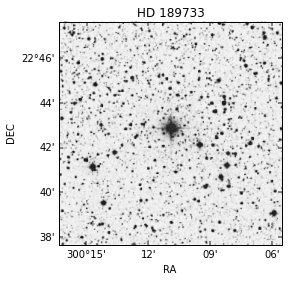

In [8]:
%matplotlib inline

target = FixedTarget.from_name('HD 189733')
ax = plot_finder_image(target)
plt.show()

Plot with my choice of colormap, reticle, with logarithmic colormap:

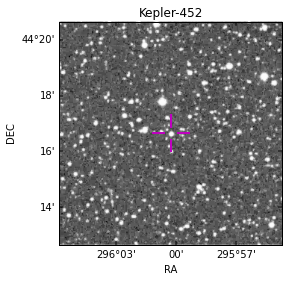

In [9]:
target = FixedTarget.from_name('Kepler-452')
ax = plot_finder_image(target, log=True, survey='DSS', fov_radius=8*u.arcmin, reticle=True,
                       style_kwargs={'cmap' : plt.cm.Greys_r})
plt.show()

Works for lots of wavelengths:

/Users/bmorris/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:74: RuntimeWarning: divide by zero encountered in log


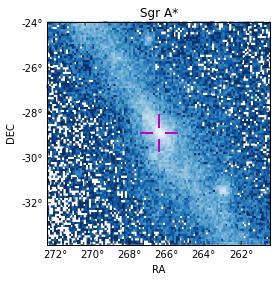

In [10]:
target = FixedTarget.from_name('Sgr A*')
ax = plot_finder_image(target, log=True, survey='Fermi 5', fov_radius=10*u.deg, reticle=True,
                       style_kwargs={'cmap' : plt.cm.Blues_r})
plt.show()

Available surveys:

In [5]:
SkyView.list_surveys()

{u'DiffuseX-ray': [u'RASS Background 1',
                   u'RASS Background 2',
                   u'RASS Background 3',
                   u'RASS Background 4',
                   u'RASS Background 5',
                   u'RASS Background 6',
                   u'RASS Background 7'],
 u'GOODS/HDF/CDF(Allwavebands)': [u'GOODS: Chandra ACIS HB',
                                  u'GOODS: Chandra ACIS FB',
                                  u'GOODS: Chandra ACIS SB',
                                  u'GOODS: VLT VIMOS U',
                                  u'GOODS: VLT VIMOS R',
                                  u'GOODS: HST ACS B',
                                  u'GOODS: HST ACS V',
                                  u'GOODS: HST ACS I',
                                  u'GOODS: HST ACS Z',
                                  u'Hawaii HDF U',
                                  u'Hawaii HDF B',
                                  u'Hawaii HDF V0201',
                                  u'Ha